In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow as imshow
import math
from google.colab import drive
from matplotlib import pyplot as plt

In [ ]:
#drive.mount('/content/drive')

#!mkdir /content/images/
#!unzip /content/drive/MyDrive/Colab\ Notebooks/simple.zip -d /content/images/

#!mkdir /content/images/simple/train
#!unzip /content/images/simple/train.zip -d /content/images/simple/train

#!unzip /content/drive/MyDrive/Colab\ Notebooks/hard.zip -d /content/images/

# Functions Localization with Contours



In [ ]:
# import the necessary packages
import numpy as np
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	#print(x1, y1, x2, y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [ ]:
def boxByContours(canny):
  contours, hierarchy = cv2.findContours(canny,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  i = 0
  boxes = []
  for cnt in contours:
      i += 1
      x,y,w,h = cv2.boundingRect(cnt)
      #roi = src[y:y+h,x:x+w]
      boxes.append([x,y,x+w,y+h])
        #imshow(cv2.resize(roi, (128,128)))
      #cv2.imwrite("/content/"+str(idx) + '.jpg', roi) #Persist roi
      #cv2.rectangle(im,(x,y),(x+w,y+h),(200,0,0),2) #Draw rectangle boundingbox
  return boxes

In [ ]:
def preprocess_canny(src_img):
  edges = cv2.Canny(src_img,100,200)
  return edges

# Example Localisation with Contours

In [ ]:
src_img = cv2.imread("/content/images/simple/train/IMG_20211121_215900.jpg")
canny = preprocess_canny(src_img)
imshow(canny)
"""
lines = cv2.HoughLines(canny,10,np.pi/90,200)
print(lines)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(src_img,(x1,y1),(x2,y2),(0,0,255),2)

cv2.imwrite('houghlines3.jpg',src_img)
"""
boxes = boxByContours(canny)
print(len(boxes))
boxes = non_max_suppression_fast(np.asarray(boxes), 0.01)
i=0
for box in boxes:
  i+=1
  imshow(src_img[box[1]:box[3],box[0]:box[2]])

# Region Fill Functions

In [ ]:
def erode(size, bin_img):
  kernel = np.ones((size, size), np.uint8)
  return cv2.erode(bin_img, kernel)

def dilate(size, bin_img):
  kernel = np.ones((size, size), np.uint8)
  return cv2.dilate(bin_img, kernel)

def open(size, bin_img):
  return dilate(size, erode(size, bin_img))

def close(size, bin_img):
  return erode(size, dilate(size, bin_img))

In [ ]:
from skimage.segmentation import flood, flood_fill

def get_box_of_bin(bin_image): # Expects a black image with exactly one white area that represents a dice  
  xmin = np.inf
  xmax = -np.inf
  ymin = np.inf
  ymax = -np.inf
  
  for idy, y in enumerate(bin_image):
    for idx, x in enumerate(y):
      if(x == 255):
        xmin = (idx if idx<xmin else xmin)
        xmax = (idx if idx>xmax else xmax)
        ymin = (idy if idy<ymin else ymin)
        ymax = (idy if idy>ymax else ymax)
  return xmin, ymin, xmax, ymax

def fill(bin_image):  # Removes One Dice from the Image
  for idy, y in enumerate(bin_image):
    for idx, x in enumerate(y):
      if(x == 255): # Find first white Pixel
        flooded = flood_fill(bin_image, (idy, idx), 0) # Fill that area connected to the pixel
        xmin, ymin, xmax, ymax = get_box_of_bin(bin_image - flooded) # Find the Area that was flooded to
        return flooded, [xmin, ymin, xmax, ymax]
  return 0, []

def get_white_boxes(bin_img): # Finds all white Boxes in the Image
  filler = bin_img
  boxes = []
  while not isinstance(filler, int):
    flooded, box = fill(filler)
    filler = flooded
    if(len(box)==4 and box[0]<box[2] and box[1]<box[3]):
      boxes.append(box)

  return boxes

In [ ]:
# Recursive Wrapper for the Boxes to make it possible to give more chances of correct opening, closing or other preprocessing
# Returns xmin, ymin, xmax, ymax 
def seperate_bin_areas(size, bin_img, seperator_f=None, i=0): 
  boxes = get_white_boxes(bin_img)
  dice_count = len(boxes)
  if dice_count == 5:
    return boxes
  elif i >= 5: #If the Recursion Depth is greater than 5 
    raise
  elif dice_count > 5:
    return seperate_bin_areas(np.ceil(size*1.25), bin_img, seperator_f=close, i=i+1)
  else:
    s = np.floor(size*1.25)
    return seperate_bin_areas((2 if s<2 else s), bin_img, seperator_f=open, i=i+1)

In [ ]:
# Reads the Image and converts it to Binary for binary_segmentation
def preprocess(src_image, blur=False):
  #src = cv2.imread(path)
  img_grey = cv2.cvtColor(src_image, cv2.COLOR_RGB2GRAY)
  if blur:
    img_grey = cv2.GaussianBlur(img_grey,(5,5),0)
  thresh, bin_img = cv2.threshold(img_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  return bin_img

# Load Model

In [ ]:
from tensorflow import keras
!unzip /content/small_cnn_100_epoch.zip -d /content/model
model = keras.models.load_model("/content/model/content/small_cnn_100_epoch")

Archive:  /content/small_cnn_100_epoch.zip
   creating: /content/model/content/small_cnn_100_epoch/
  inflating: /content/model/content/small_cnn_100_epoch/keras_metadata.pb  
   creating: /content/model/content/small_cnn_100_epoch/variables/
  inflating: /content/model/content/small_cnn_100_epoch/variables/variables.index  
  inflating: /content/model/content/small_cnn_100_epoch/variables/variables.data-00000-of-00001  
   creating: /content/model/content/small_cnn_100_epoch/assets/
  inflating: /content/model/content/small_cnn_100_epoch/saved_model.pb  


# Example of Region Fill Segmentation

In [ ]:
src_img = cv2.imread("/content/images/simple/train/IMG_20211121_215900.jpg")
bin_img = preprocess(src_img)
#plt.imshow(bin_img, cmap='gray')
boxes = seperate_bin_areas(4, bin_img)
print(boxes)
box = boxes[4]
plt.imshow(cv2.resize(src_img[box[1]:box[3], box[0]:box[2]], (28,28)), cmap='gray')


In [ ]:
feed_forward(cv2.resize(src_img[box[1]:box[3], box[0]:box[2]], (28,28)), model)

# End to End Pipeline Image to Boxes and Classe

In [ ]:
def get_boxes(input_img, function="binary"):
  boxes = []
  if function=="binary":
    bin_img = preprocess(input_img)
    return seperate_bin_areas(4, bin_img)
  elif function=="contours":
    canny = preprocess_canny(input_img)
    #canny = cv2.HoughLines(canny,1,np.pi/180,200)
    boxes = boxByContours(canny)
    boxes = non_max_suppression_fast(np.asarray(boxes), 0.8)
    return boxes

In [ ]:
global timers
timers = []
def feed_forward(dice_img, model):
  equisized = cv2.resize(dice_img, (28,28))#Todo view
  monochromed = cv2.cvtColor(equisized, cv2.COLOR_BGR2GRAY) # Color doesnt matter for dices
  normalized = monochromed / 255.0 # Normalize pixel values to be between 0 and 1 
  prediction = model.predict(normalized.reshape(1,28,28,-1))
  return prediction

#Returns List with 5 tuples like (box, eyes); Expected to be one for each dice
def predict(src_image, model):
  eyes = []
  boxes = []

  """Get Boxes"""
  start = time.time()
  boxes = get_boxes(src_image, function="binary") # Throws error if Could not identify 5 Boxes
  end = time.time()
  timers.append(end-start)

  """For each Box, predict Eyes"""
  for idx, box in enumerate(boxes):
    dice_img = src_image[box[1]:box[3], box[0]:box[2]]
    class_prediction = feed_forward(dice_img, model)
    eyes.append(np.argmax(class_prediction))
    #imshow(dice_img)
  
  return ((boxes[0],eyes[0]),
          (boxes[1],eyes[1]),
          (boxes[2],eyes[2]),
          (boxes[3],eyes[3]),
          (boxes[4],eyes[4]))

# Evaluation Pipeline

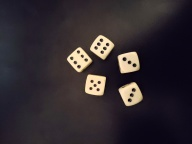

0.7293448448181152


In [ ]:
import pandas as pd
import time
df = pd.read_pickle("/content/simple-train-cropped.pkl")
imshow(df.iloc[26].img)
predict(df.iloc[26].img, model)

In [ ]:
# Amount of Images with not 5 Boxes
boxes = []
not_five_boxes = 0
times = []
for image_name in df.name.unique():
  single_image = df[df["name"] == image_name].iloc[0]
  try:
    #print("next Dice")
    #start = time.time()
    boxes.append(predict(single_image.img, model))
    #end = time.time()
    #times.append(end-start)
  except Exception as e:
    print(e)

print(not_five_boxes)
print(np.average(timers))

No active exception to reraise
No active exception to reraise
No active exception to reraise
No active exception to reraise
No active exception to reraise
No active exception to reraise
No active exception to reraise
0
0.3618386766184931


In [ ]:
len(test_df.name.unique())

32

In [ ]:
len(boxes)

32

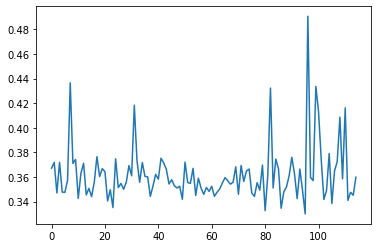

In [ ]:
plt.plot(timers)

In [ ]:
np.average(timers)

0.3618386766184931

In [ ]:
!df -h

In [ ]:
!cat /proc/cpuinfo